In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import tables

# SIMF

Load the `simf` module.

In [2]:
# make sure the module is in path
if '..' not in sys.path:
    sys.path.append('..')

from simf import *
from simf.common import split_streams, build_test_set, build_sparse_matrix

## Load data

Read *yelp* data on *users*, *bars*, *hotels* and *restaurants*.

The data covers the period from 2.7.2017 to 2.7.2018.

In [3]:
with tables.open_file('data/yelp_users-restaurants.tbl', 'r') as h5_file:
    s1 = h5_file.root.data.read()
with tables.open_file('data/yelp_users-bars.tbl', 'r') as h5_file:
    s2 = h5_file.root.data.read()
with tables.open_file('data/yelp_users-hotels.tbl', 'r') as h5_file:
    s3 = h5_file.root.data.read()

# Create data streams
train_ur, train_ub, train_uh, test_ur, test_ub, test_uh = split_streams([s1, s2, s3], t=1508546800)
test_set = build_test_set(test_ur)

# Create object types and relations
o_users = ObjectType('users', 25)
o_restaurants = ObjectType('restaurants', 10)
o_bars = ObjectType('bars', 10)
o_hotels = ObjectType('hotels', 10)
r_ur = Relation(o_users, o_restaurants, build_sparse_matrix(train_ur), weight=1)
r_ub = Relation(o_users, o_bars, build_sparse_matrix(train_ub), weight=1)
r_uh = Relation(o_users, o_hotels, build_sparse_matrix(train_uh), weight=1)

Data is encoded in sparse format, and includes:
* row
* column
* value
* timestamp

For example, let's look at stream 1:

In [4]:
s1.shape

(4, 589772)

There are 21936 data points. Let's look at the first three entries:

In [5]:
s1[:,:3]

array([[         0,          1,          1],
       [         0,          1,          2],
       [         4,          4,          5],
       [1505772000, 1505772000, 1505772000]], dtype=int32)

The data is divided into the pretraining (from 2.7.2017 to 20.10.2017) and streaming set (from 21.10.2017 to 2.7.2018). The split date is set when calling the `split_streams` function with parameter `t=1508546800`.

## Pick models to test

In [6]:
models = {
    'Average': Average(),
    'RMF': RMF(rank=25, max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008),
    'SIMF_X3_CB': SIMF(max_iter=20, regularization=0.005, learning_rate=0.008, combine_bias=True),
}

## Pretraining

In [7]:
def pre_train_models(models, relations, streams):
    main_relation = relations[0]
    test_set = build_test_set(streams[0])
    # Iterate through models
    for m_name, m in models.items():
        print(m_name)
        data = [main_relation]
        if "X3" in m_name:
            data = relations
        # Fit models
        m.fit(data=data, verbose=True)
        # Calculate the error (train and test - remaining stream)
        print("Train error: RMSE:%f,  MAE:%f" % m.get_train_error()[main_relation])
        print("Test error: RMSE:%f,  MAE:%f\n" % m.get_test_error(main_relation, test_set)[main_relation])
    print("Initial factorization complete")
    return models

## Streaming phase

In [8]:
def evaluate_stream(models, relations, streams, update_interval=3600, max_iter=3, max_updates=None):
    r1, r2, r3 = relations
    results = {}
    # Update models with new params
    for n, m in models.items():
        m.max_iter = max_iter
    print("Starting streaming phase\n")
    for k, s in enumerate(streams):
        streams[k] = list([
            [int(x) for x in s[0]],
            [int(x) for x in s[1]],
            [float(x) for x in s[2]],
            [int(x) for x in s[3]]]
        )
    # Sliding windows of stream data - discrete intervals [current_ts, next_ts]
    current_ts = streams[0][3][0]
    next_ts = current_ts + update_interval
    windows = [[] for k in streams]

    i = 0
    # End when main stream runs out of instances
    while len(streams[0][3]) > 0:
        if max_updates and i >= max_updates:
            break
        row, col, val, ts = [], [], [], []
        # Pop elements into the window
        for k, s in enumerate(streams):
            while len(s[3]) > 0 and s[3][0] <= next_ts:
                row.append(s[0].pop(0))
                col.append(s[1].pop(0))
                val.append(s[2].pop(0))
                ts.append(s[3].pop(0))
            windows[k] = [row, col, val, ts]
            row, col, val, ts = [], [], [], []

        # Continue with next window if no updates on main relation
        if float(len(windows[0][0])) < 1:
            current_ts += update_interval
            next_ts += update_interval
            continue
        # Get true values from the main stream
        true_values = np.array(windows[0][2])
        average_rmse = None

        print("Window: ", i, current_ts, next_ts)
        # Loop through all models
        for m_name, m in models.items():
            # Get predictions for the current window
            predictions = m.predict_stream(r1, list(zip(*windows[0][:3])), verbose=False)
            # Get the error of the average predictor (for calculating rrmse)
            if m_name == 'Average':
                average_rmse = m.rmse(true_values, predictions)
            # Get the error for other predictors and calculate the rrmse
            mrmse = m.rmse(true_values, predictions)
            rrmse = mrmse / average_rmse
            print("%s window error: RMSE:%f,  RRMSE:%f" % (m_name, mrmse, rrmse))
            # Append results
            if m_name not in results:
                results[m_name] = ([mrmse], [rrmse])
            else:
                results[m_name][0].append(mrmse)
                results[m_name][1].append(rrmse)

            # Update models
            r1.set_matrix(build_sparse_matrix(windows[0][:3]))
            r2.set_matrix(build_sparse_matrix(windows[1][:3]))
            r3.set_matrix(build_sparse_matrix(windows[2][:3]))
            data = [r1]
            if "X3" in m_name:
                data = [r1, r2, r3]
            m.fit_update(data=data, verbose=False)

        # Update the interval
        current_ts += update_interval
        next_ts += update_interval
        i += 1
        print()
    return results

In [9]:
def plot_results(results, plot_rrmse=True, l=0.99, title='', save_to_file=None, ylim=None):
    plt.figure()
    for name, res in results.items():
        rrmses = res[int(plot_rrmse)]
        preq_errors = []
        si = 0
        ni = 0
        mdata = np.array(rrmses)
        for r in mdata:
            r = float(r)
            si = r + l * si
            ni = 1 + l * ni
            preq_errors.append(si / float(ni))
        plt.plot(range(len(preq_errors)), preq_errors, label=name)

    if ylim:
        plt.ylim(ylim)

    plt.ylabel('Prequential RRMSE')
    plt.xlabel('Instances (Updates)')
    plt.title(title)
    plt.legend()
    plt.show()
    if save_to_file:
        plt.savefig(save_to_file, bbox_inches='tight')

# Two examples

## Recommending *restaurants*

### Initial factorization

In [10]:
models = pre_train_models(models, [r_ur, r_ub, r_uh], [test_ur, test_ub, test_uh])

Average
2019-04-15 09:44:51,125: Fitting the average model: bias=True, update=True
2019-04-15 09:44:51,163: Fit complete in 0.037322998046875 seconds
Train error: RMSE:1.240055,  MAE:1.025735
Test error: RMSE:1.400745,  MAE:1.165995

RMF
2019-04-15 09:44:53,020: Initialization complete in 0.08725214004516602 seconds
2019-04-15 09:44:53,021: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 09:45:18,630: Factorization complete in 25.69749903678894 seconds
Train error: RMSE:0.855449,  MAE:0.672153
Test error: RMSE:1.396096,  MAE:1.162920

SIMF
2019-04-15 09:45:23,446: Initialization complete in 0.09932494163513184 seconds
2019-04-15 09:45:23,447: Factorizing (SGD) 1 relations: bias=True, max_iter=20, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 09:46:08,340: Factorization complete in 44.99257802963257 seconds
Train error: RMSE:0.881399,  MAE:0.724282
Test error: RMSE:1.396782,  MAE

### Stream evaluation

In [11]:
results = evaluate_stream(models, [r_ur, r_ub, r_uh], [test_ur, test_ub, test_uh])

Starting streaming phase

Window:  0 1508623200 1508626800
Average window error: RMSE:1.449288,  RRMSE:1.000000
RMF window error: RMSE:1.439111,  RRMSE:0.992978
SIMF window error: RMSE:1.456399,  RRMSE:1.004906
SIMF_X3 window error: RMSE:1.447308,  RRMSE:0.998634
SIMF_X3_CB window error: RMSE:1.444739,  RRMSE:0.996861

Window:  1 1508706000 1508709600
Average window error: RMSE:1.468710,  RRMSE:1.000000
RMF window error: RMSE:1.419837,  RRMSE:0.966724
SIMF window error: RMSE:1.415873,  RRMSE:0.964025
SIMF_X3 window error: RMSE:1.409720,  RRMSE:0.959835
SIMF_X3_CB window error: RMSE:1.409718,  RRMSE:0.959835

Window:  2 1508792400 1508796000
Average window error: RMSE:1.390121,  RRMSE:1.000000
RMF window error: RMSE:1.325042,  RRMSE:0.953185
SIMF window error: RMSE:1.309903,  RRMSE:0.942294
SIMF_X3 window error: RMSE:1.310243,  RRMSE:0.942538
SIMF_X3_CB window error: RMSE:1.309820,  RRMSE:0.942234

Window:  3 1508878800 1508882400
Average window error: RMSE:1.410646,  RRMSE:1.000000
RMF

SIMF_X3 window error: RMSE:1.374762,  RRMSE:0.958220
SIMF_X3_CB window error: RMSE:1.375270,  RRMSE:0.958574

Window:  28 1511042400 1511046000
Average window error: RMSE:1.468656,  RRMSE:1.000000
RMF window error: RMSE:1.402864,  RRMSE:0.955203
SIMF window error: RMSE:1.403353,  RRMSE:0.955536
SIMF_X3 window error: RMSE:1.394197,  RRMSE:0.949301
SIMF_X3_CB window error: RMSE:1.396294,  RRMSE:0.950729

Window:  29 1511128800 1511132400
Average window error: RMSE:1.465464,  RRMSE:1.000000
RMF window error: RMSE:1.407109,  RRMSE:0.960180
SIMF window error: RMSE:1.409004,  RRMSE:0.961473
SIMF_X3 window error: RMSE:1.405289,  RRMSE:0.958937
SIMF_X3_CB window error: RMSE:1.403369,  RRMSE:0.957628

Window:  30 1511215200 1511218800
Average window error: RMSE:1.392194,  RRMSE:1.000000
RMF window error: RMSE:1.329351,  RRMSE:0.954861
SIMF window error: RMSE:1.314285,  RRMSE:0.944039
SIMF_X3 window error: RMSE:1.318037,  RRMSE:0.946734
SIMF_X3_CB window error: RMSE:1.317627,  RRMSE:0.946440

Wi

SIMF_X3 window error: RMSE:1.398352,  RRMSE:0.939194
SIMF_X3_CB window error: RMSE:1.397728,  RRMSE:0.938775

Window:  56 1513461600 1513465200
Average window error: RMSE:1.479507,  RRMSE:1.000000
RMF window error: RMSE:1.408705,  RRMSE:0.952145
SIMF window error: RMSE:1.409122,  RRMSE:0.952427
SIMF_X3 window error: RMSE:1.402881,  RRMSE:0.948208
SIMF_X3_CB window error: RMSE:1.403579,  RRMSE:0.948680

Window:  57 1513548000 1513551600
Average window error: RMSE:1.484947,  RRMSE:1.000000
RMF window error: RMSE:1.407496,  RRMSE:0.947842
SIMF window error: RMSE:1.412072,  RRMSE:0.950924
SIMF_X3 window error: RMSE:1.403908,  RRMSE:0.945426
SIMF_X3_CB window error: RMSE:1.402226,  RRMSE:0.944293

Window:  58 1513634400 1513638000
Average window error: RMSE:1.405792,  RRMSE:1.000000
RMF window error: RMSE:1.341419,  RRMSE:0.954209
SIMF window error: RMSE:1.331928,  RRMSE:0.947458
SIMF_X3 window error: RMSE:1.330663,  RRMSE:0.946558
SIMF_X3_CB window error: RMSE:1.331610,  RRMSE:0.947231

Wi

SIMF_X3 window error: RMSE:1.345477,  RRMSE:0.950042
SIMF_X3_CB window error: RMSE:1.344527,  RRMSE:0.949372

Window:  84 1515880800 1515884400
Average window error: RMSE:1.479652,  RRMSE:1.000000
RMF window error: RMSE:1.407942,  RRMSE:0.951536
SIMF window error: RMSE:1.419398,  RRMSE:0.959278
SIMF_X3 window error: RMSE:1.399378,  RRMSE:0.945748
SIMF_X3_CB window error: RMSE:1.400805,  RRMSE:0.946712

Window:  85 1515967200 1515970800
Average window error: RMSE:1.411017,  RRMSE:1.000000
RMF window error: RMSE:1.339039,  RRMSE:0.948988
SIMF window error: RMSE:1.336602,  RRMSE:0.947262
SIMF_X3 window error: RMSE:1.339829,  RRMSE:0.949548
SIMF_X3_CB window error: RMSE:1.338759,  RRMSE:0.948791

Window:  86 1516053600 1516057200
Average window error: RMSE:1.374638,  RRMSE:1.000000
RMF window error: RMSE:1.293056,  RRMSE:0.940652
SIMF window error: RMSE:1.288187,  RRMSE:0.937111
SIMF_X3 window error: RMSE:1.283026,  RRMSE:0.933356
SIMF_X3_CB window error: RMSE:1.282087,  RRMSE:0.932672

Wi

SIMF_X3 window error: RMSE:1.381969,  RRMSE:0.951459
SIMF_X3_CB window error: RMSE:1.382116,  RRMSE:0.951560

Window:  112 1518300000 1518303600
Average window error: RMSE:1.447418,  RRMSE:1.000000
RMF window error: RMSE:1.380335,  RRMSE:0.953653
SIMF window error: RMSE:1.380725,  RRMSE:0.953923
SIMF_X3 window error: RMSE:1.368589,  RRMSE:0.945538
SIMF_X3_CB window error: RMSE:1.372287,  RRMSE:0.948093

Window:  113 1518386400 1518390000
Average window error: RMSE:1.433593,  RRMSE:1.000000
RMF window error: RMSE:1.359875,  RRMSE:0.948578
SIMF window error: RMSE:1.356010,  RRMSE:0.945882
SIMF_X3 window error: RMSE:1.354766,  RRMSE:0.945015
SIMF_X3_CB window error: RMSE:1.350798,  RRMSE:0.942247

Window:  114 1518472800 1518476400
Average window error: RMSE:1.403743,  RRMSE:1.000000
RMF window error: RMSE:1.346474,  RRMSE:0.959203
SIMF window error: RMSE:1.349053,  RRMSE:0.961040
SIMF_X3 window error: RMSE:1.344048,  RRMSE:0.957475
SIMF_X3_CB window error: RMSE:1.342283,  RRMSE:0.956217


SIMF window error: RMSE:1.358562,  RRMSE:0.944919
SIMF_X3 window error: RMSE:1.344900,  RRMSE:0.935417
SIMF_X3_CB window error: RMSE:1.345549,  RRMSE:0.935868

Window:  140 1520719200 1520722800
Average window error: RMSE:1.466159,  RRMSE:1.000000
RMF window error: RMSE:1.377880,  RRMSE:0.939789
SIMF window error: RMSE:1.381453,  RRMSE:0.942226
SIMF_X3 window error: RMSE:1.367389,  RRMSE:0.932634
SIMF_X3_CB window error: RMSE:1.368331,  RRMSE:0.933276

Window:  141 1520805600 1520809200
Average window error: RMSE:1.449808,  RRMSE:1.000000
RMF window error: RMSE:1.369344,  RRMSE:0.944500
SIMF window error: RMSE:1.370905,  RRMSE:0.945577
SIMF_X3 window error: RMSE:1.361120,  RRMSE:0.938828
SIMF_X3_CB window error: RMSE:1.358129,  RRMSE:0.936765

Window:  142 1520892000 1520895600
Average window error: RMSE:1.411364,  RRMSE:1.000000
RMF window error: RMSE:1.336803,  RRMSE:0.947171
SIMF window error: RMSE:1.336000,  RRMSE:0.946602
SIMF_X3 window error: RMSE:1.333901,  RRMSE:0.945115
SIMF_X

SIMF window error: RMSE:1.377030,  RRMSE:0.944542
SIMF_X3 window error: RMSE:1.369730,  RRMSE:0.939535
SIMF_X3_CB window error: RMSE:1.368694,  RRMSE:0.938825

Window:  168 1523134800 1523138400
Average window error: RMSE:1.502095,  RRMSE:1.000000
RMF window error: RMSE:1.429752,  RRMSE:0.951839
SIMF window error: RMSE:1.432248,  RRMSE:0.953500
SIMF_X3 window error: RMSE:1.421331,  RRMSE:0.946232
SIMF_X3_CB window error: RMSE:1.421047,  RRMSE:0.946043

Window:  169 1523221200 1523224800
Average window error: RMSE:1.416446,  RRMSE:1.000000
RMF window error: RMSE:1.336058,  RRMSE:0.943247
SIMF window error: RMSE:1.331662,  RRMSE:0.940143
SIMF_X3 window error: RMSE:1.323827,  RRMSE:0.934612
SIMF_X3_CB window error: RMSE:1.327820,  RRMSE:0.937431

Window:  170 1523307600 1523311200
Average window error: RMSE:1.375093,  RRMSE:1.000000
RMF window error: RMSE:1.281169,  RRMSE:0.931697
SIMF window error: RMSE:1.273306,  RRMSE:0.925978
SIMF_X3 window error: RMSE:1.274949,  RRMSE:0.927173
SIMF_X

SIMF_X3 window error: RMSE:1.407491,  RRMSE:0.938809
SIMF_X3_CB window error: RMSE:1.409759,  RRMSE:0.940322

Window:  196 1525554000 1525557600
Average window error: RMSE:1.475906,  RRMSE:1.000000
RMF window error: RMSE:1.387260,  RRMSE:0.939938
SIMF window error: RMSE:1.389257,  RRMSE:0.941291
SIMF_X3 window error: RMSE:1.375713,  RRMSE:0.932114
SIMF_X3_CB window error: RMSE:1.378830,  RRMSE:0.934226

Window:  197 1525640400 1525644000
Average window error: RMSE:1.420306,  RRMSE:1.000000
RMF window error: RMSE:1.337202,  RRMSE:0.941488
SIMF window error: RMSE:1.336360,  RRMSE:0.940896
SIMF_X3 window error: RMSE:1.331625,  RRMSE:0.937562
SIMF_X3_CB window error: RMSE:1.331956,  RRMSE:0.937795

Window:  198 1525726800 1525730400
Average window error: RMSE:1.431698,  RRMSE:1.000000
RMF window error: RMSE:1.324746,  RRMSE:0.925298
SIMF window error: RMSE:1.319938,  RRMSE:0.921939
SIMF_X3 window error: RMSE:1.312501,  RRMSE:0.916745
SIMF_X3_CB window error: RMSE:1.309114,  RRMSE:0.914379


SIMF_X3 window error: RMSE:1.347663,  RRMSE:0.936836
SIMF_X3_CB window error: RMSE:1.346554,  RRMSE:0.936065

Window:  224 1527973200 1527976800
Average window error: RMSE:1.441881,  RRMSE:1.000000
RMF window error: RMSE:1.347012,  RRMSE:0.934205
SIMF window error: RMSE:1.347727,  RRMSE:0.934700
SIMF_X3 window error: RMSE:1.339715,  RRMSE:0.929144
SIMF_X3_CB window error: RMSE:1.338174,  RRMSE:0.928075

Window:  225 1528059600 1528063200
Average window error: RMSE:1.447316,  RRMSE:1.000000
RMF window error: RMSE:1.363851,  RRMSE:0.942331
SIMF window error: RMSE:1.363399,  RRMSE:0.942019
SIMF_X3 window error: RMSE:1.350885,  RRMSE:0.933373
SIMF_X3_CB window error: RMSE:1.352558,  RRMSE:0.934528

Window:  226 1528146000 1528149600
Average window error: RMSE:1.402881,  RRMSE:1.000000
RMF window error: RMSE:1.302439,  RRMSE:0.928403
SIMF window error: RMSE:1.300165,  RRMSE:0.926783
SIMF_X3 window error: RMSE:1.291769,  RRMSE:0.920798
SIMF_X3_CB window error: RMSE:1.291000,  RRMSE:0.920249


SIMF window error: RMSE:1.367320,  RRMSE:0.939718
SIMF_X3 window error: RMSE:1.361364,  RRMSE:0.935625
SIMF_X3_CB window error: RMSE:1.361512,  RRMSE:0.935727

Window:  252 1530392400 1530396000
Average window error: RMSE:1.475790,  RRMSE:1.000000
RMF window error: RMSE:1.382446,  RRMSE:0.936750
SIMF window error: RMSE:1.385296,  RRMSE:0.938681
SIMF_X3 window error: RMSE:1.371830,  RRMSE:0.929556
SIMF_X3_CB window error: RMSE:1.371693,  RRMSE:0.929464

Window:  253 1530478800 1530482400
Average window error: RMSE:1.487953,  RRMSE:1.000000
RMF window error: RMSE:1.401081,  RRMSE:0.941617
SIMF window error: RMSE:1.400509,  RRMSE:0.941232
SIMF_X3 window error: RMSE:1.388206,  RRMSE:0.932964
SIMF_X3_CB window error: RMSE:1.387978,  RRMSE:0.932811



### Plot prequential RRMSE

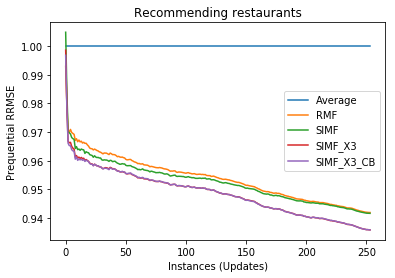

In [12]:
plot_results(results, title='Recommending restaurants')

## Recommending *bars*

### Initial factorization

In [13]:
models = pre_train_models(models, [r_ub, r_uh, r_ur], [test_ub, test_uh, test_ur])

Average
2019-04-15 10:00:41,817: Fitting the average model: bias=True, update=True
2019-04-15 10:00:41,844: Fit complete in 0.025969982147216797 seconds
Train error: RMSE:1.333169,  MAE:1.136226
Test error: RMSE:1.451131,  MAE:1.287774

RMF
2019-04-15 10:00:42,218: Initialization complete in 0.31087589263916016 seconds
2019-04-15 10:00:42,219: Factorizing (SGD) 1 relations: bias=True, max_iter=3, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 10:00:42,222: Factorization complete in 0.31497979164123535 seconds
Train error: RMSE:1.280941,  MAE:1.013460
Test error: RMSE:1.425849,  MAE:1.184210

SIMF
2019-04-15 10:00:42,647: Initialization complete in 0.31366491317749023 seconds
2019-04-15 10:00:42,648: Factorizing (SGD) 1 relations: bias=True, max_iter=3, bias=True, regularization=0.005, learning rate=0.008 epsilon=0
2019-04-15 10:00:42,653: Factorization complete in 0.31960177421569824 seconds
Train error: RMSE:1.230663,  MAE:0.980458
Test error: RMSE:1.427629,

### Stream evaluation

In [14]:
results = evaluate_stream(models, [r_ub, r_uh, r_ur], [test_ub, test_uh, test_ur])

Starting streaming phase

Window:  0 1508623200 1508626800
Average window error: RMSE:1.485464,  RRMSE:1.000000
RMF window error: RMSE:1.506243,  RRMSE:1.013988
SIMF window error: RMSE:1.492205,  RRMSE:1.004538
SIMF_X3 window error: RMSE:1.489189,  RRMSE:1.002508
SIMF_X3_CB window error: RMSE:1.475001,  RRMSE:0.992956

Window:  1 1508706000 1508709600
Average window error: RMSE:1.439085,  RRMSE:1.000000
RMF window error: RMSE:1.457126,  RRMSE:1.012536
SIMF window error: RMSE:1.429520,  RRMSE:0.993353
SIMF_X3 window error: RMSE:1.442626,  RRMSE:1.002460
SIMF_X3_CB window error: RMSE:1.425347,  RRMSE:0.990453

Window:  2 1508792400 1508796000
Average window error: RMSE:1.250762,  RRMSE:1.000000
RMF window error: RMSE:1.206602,  RRMSE:0.964694
SIMF window error: RMSE:1.214423,  RRMSE:0.970946
SIMF_X3 window error: RMSE:1.217073,  RRMSE:0.973065
SIMF_X3_CB window error: RMSE:1.241305,  RRMSE:0.992439

Window:  3 1508878800 1508882400
Average window error: RMSE:1.439937,  RRMSE:1.000000
RMF

SIMF_X3_CB window error: RMSE:1.473570,  RRMSE:0.989633

Window:  28 1511042400 1511046000
Average window error: RMSE:1.328204,  RRMSE:1.000000
RMF window error: RMSE:1.340299,  RRMSE:1.009106
SIMF window error: RMSE:1.309431,  RRMSE:0.985866
SIMF_X3 window error: RMSE:1.318772,  RRMSE:0.992899
SIMF_X3_CB window error: RMSE:1.315273,  RRMSE:0.990265

Window:  29 1511128800 1511132400
Average window error: RMSE:1.454433,  RRMSE:1.000000
RMF window error: RMSE:1.483797,  RRMSE:1.020189
SIMF window error: RMSE:1.444779,  RRMSE:0.993362
SIMF_X3 window error: RMSE:1.443849,  RRMSE:0.992723
SIMF_X3_CB window error: RMSE:1.434404,  RRMSE:0.986229

Window:  30 1511215200 1511218800
Average window error: RMSE:1.416348,  RRMSE:1.000000
RMF window error: RMSE:1.377234,  RRMSE:0.972384
SIMF window error: RMSE:1.379696,  RRMSE:0.974122
SIMF_X3 window error: RMSE:1.382279,  RRMSE:0.975946
SIMF_X3_CB window error: RMSE:1.381909,  RRMSE:0.975685

Window:  31 1511301600 1511305200
Average window error:

SIMF_X3_CB window error: RMSE:1.203787,  RRMSE:0.969702

Window:  56 1513461600 1513465200
Average window error: RMSE:1.589046,  RRMSE:1.000000
RMF window error: RMSE:1.619070,  RRMSE:1.018895
SIMF window error: RMSE:1.578630,  RRMSE:0.993445
SIMF_X3 window error: RMSE:1.574409,  RRMSE:0.990789
SIMF_X3_CB window error: RMSE:1.579807,  RRMSE:0.994186

Window:  57 1513548000 1513551600
Average window error: RMSE:1.464175,  RRMSE:1.000000
RMF window error: RMSE:1.442985,  RRMSE:0.985528
SIMF window error: RMSE:1.432479,  RRMSE:0.978353
SIMF_X3 window error: RMSE:1.429507,  RRMSE:0.976322
SIMF_X3_CB window error: RMSE:1.407190,  RRMSE:0.961080

Window:  58 1513634400 1513638000
Average window error: RMSE:1.370562,  RRMSE:1.000000
RMF window error: RMSE:1.291179,  RRMSE:0.942081
SIMF window error: RMSE:1.340435,  RRMSE:0.978019
SIMF_X3 window error: RMSE:1.347284,  RRMSE:0.983016
SIMF_X3_CB window error: RMSE:1.335340,  RRMSE:0.974301

Window:  59 1513720800 1513724400
Average window error:

SIMF_X3_CB window error: RMSE:1.425336,  RRMSE:0.998325

Window:  84 1515880800 1515884400
Average window error: RMSE:1.654965,  RRMSE:1.000000
RMF window error: RMSE:1.710943,  RRMSE:1.033824
SIMF window error: RMSE:1.638567,  RRMSE:0.990091
SIMF_X3 window error: RMSE:1.637835,  RRMSE:0.989649
SIMF_X3_CB window error: RMSE:1.632511,  RRMSE:0.986432

Window:  85 1515967200 1515970800
Average window error: RMSE:1.430602,  RRMSE:1.000000
RMF window error: RMSE:1.365689,  RRMSE:0.954625
SIMF window error: RMSE:1.361019,  RRMSE:0.951361
SIMF_X3 window error: RMSE:1.368964,  RRMSE:0.956915
SIMF_X3_CB window error: RMSE:1.361373,  RRMSE:0.951608

Window:  86 1516053600 1516057200
Average window error: RMSE:1.558981,  RRMSE:1.000000
RMF window error: RMSE:1.574961,  RRMSE:1.010250
SIMF window error: RMSE:1.529705,  RRMSE:0.981221
SIMF_X3 window error: RMSE:1.537259,  RRMSE:0.986066
SIMF_X3_CB window error: RMSE:1.527667,  RRMSE:0.979913

Window:  87 1516140000 1516143600
Average window error:

SIMF_X3_CB window error: RMSE:1.470216,  RRMSE:0.980855

Window:  112 1518300000 1518303600
Average window error: RMSE:1.559606,  RRMSE:1.000000
RMF window error: RMSE:1.471460,  RRMSE:0.943482
SIMF window error: RMSE:1.480177,  RRMSE:0.949071
SIMF_X3 window error: RMSE:1.471932,  RRMSE:0.943784
SIMF_X3_CB window error: RMSE:1.461917,  RRMSE:0.937363

Window:  113 1518386400 1518390000
Average window error: RMSE:1.362595,  RRMSE:1.000000
RMF window error: RMSE:1.281927,  RRMSE:0.940799
SIMF window error: RMSE:1.269475,  RRMSE:0.931660
SIMF_X3 window error: RMSE:1.277812,  RRMSE:0.937779
SIMF_X3_CB window error: RMSE:1.272044,  RRMSE:0.933545

Window:  114 1518472800 1518476400
Average window error: RMSE:1.642348,  RRMSE:1.000000
RMF window error: RMSE:1.605051,  RRMSE:0.977290
SIMF window error: RMSE:1.567914,  RRMSE:0.954678
SIMF_X3 window error: RMSE:1.566216,  RRMSE:0.953644
SIMF_X3_CB window error: RMSE:1.566387,  RRMSE:0.953749

Window:  115 1518559200 1518562800
Average window er

SIMF_X3_CB window error: RMSE:1.343806,  RRMSE:0.925649

Window:  140 1520719200 1520722800
Average window error: RMSE:1.333308,  RRMSE:1.000000
RMF window error: RMSE:1.298860,  RRMSE:0.974163
SIMF window error: RMSE:1.281504,  RRMSE:0.961146
SIMF_X3 window error: RMSE:1.292737,  RRMSE:0.969571
SIMF_X3_CB window error: RMSE:1.283865,  RRMSE:0.962917

Window:  141 1520805600 1520809200
Average window error: RMSE:1.144641,  RRMSE:1.000000
RMF window error: RMSE:1.080723,  RRMSE:0.944159
SIMF window error: RMSE:1.093316,  RRMSE:0.955161
SIMF_X3 window error: RMSE:1.102735,  RRMSE:0.963390
SIMF_X3_CB window error: RMSE:1.087999,  RRMSE:0.950515

Window:  142 1520892000 1520895600
Average window error: RMSE:1.301443,  RRMSE:1.000000
RMF window error: RMSE:1.225809,  RRMSE:0.941885
SIMF window error: RMSE:1.191457,  RRMSE:0.915489
SIMF_X3 window error: RMSE:1.195882,  RRMSE:0.918890
SIMF_X3_CB window error: RMSE:1.201414,  RRMSE:0.923140

Window:  143 1520978400 1520982000
Average window er

SIMF_X3_CB window error: RMSE:1.347754,  RRMSE:0.929486

Window:  168 1523134800 1523138400
Average window error: RMSE:1.373454,  RRMSE:1.000000
RMF window error: RMSE:1.334394,  RRMSE:0.971561
SIMF window error: RMSE:1.358330,  RRMSE:0.988988
SIMF_X3 window error: RMSE:1.355003,  RRMSE:0.986566
SIMF_X3_CB window error: RMSE:1.356460,  RRMSE:0.987626

Window:  169 1523221200 1523224800
Average window error: RMSE:1.322847,  RRMSE:1.000000
RMF window error: RMSE:1.295908,  RRMSE:0.979636
SIMF window error: RMSE:1.270095,  RRMSE:0.960123
SIMF_X3 window error: RMSE:1.260567,  RRMSE:0.952920
SIMF_X3_CB window error: RMSE:1.249406,  RRMSE:0.944483

Window:  170 1523307600 1523311200
Average window error: RMSE:1.294875,  RRMSE:1.000000
RMF window error: RMSE:1.245765,  RRMSE:0.962074
SIMF window error: RMSE:1.247515,  RRMSE:0.963425
SIMF_X3 window error: RMSE:1.229758,  RRMSE:0.949712
SIMF_X3_CB window error: RMSE:1.216005,  RRMSE:0.939090

Window:  171 1523394000 1523397600
Average window er

SIMF_X3_CB window error: RMSE:1.442596,  RRMSE:0.960491

Window:  196 1525554000 1525557600
Average window error: RMSE:1.606013,  RRMSE:1.000000
RMF window error: RMSE:1.491958,  RRMSE:0.928982
SIMF window error: RMSE:1.490238,  RRMSE:0.927911
SIMF_X3 window error: RMSE:1.480921,  RRMSE:0.922110
SIMF_X3_CB window error: RMSE:1.477188,  RRMSE:0.919785

Window:  197 1525640400 1525644000
Average window error: RMSE:1.500467,  RRMSE:1.000000
RMF window error: RMSE:1.397758,  RRMSE:0.931549
SIMF window error: RMSE:1.366556,  RRMSE:0.910754
SIMF_X3 window error: RMSE:1.371858,  RRMSE:0.914287
SIMF_X3_CB window error: RMSE:1.339123,  RRMSE:0.892470

Window:  198 1525726800 1525730400
Average window error: RMSE:1.372980,  RRMSE:1.000000
RMF window error: RMSE:1.368497,  RRMSE:0.996735
SIMF window error: RMSE:1.365365,  RRMSE:0.994454
SIMF_X3 window error: RMSE:1.363795,  RRMSE:0.993311
SIMF_X3_CB window error: RMSE:1.353454,  RRMSE:0.985779

Window:  199 1525813200 1525816800
Average window er

SIMF_X3_CB window error: RMSE:1.389791,  RRMSE:1.011649

Window:  224 1527973200 1527976800
Average window error: RMSE:1.452048,  RRMSE:1.000000
RMF window error: RMSE:1.433103,  RRMSE:0.986953
SIMF window error: RMSE:1.420536,  RRMSE:0.978298
SIMF_X3 window error: RMSE:1.386116,  RRMSE:0.954594
SIMF_X3_CB window error: RMSE:1.380180,  RRMSE:0.950506

Window:  225 1528059600 1528063200
Average window error: RMSE:1.532798,  RRMSE:1.000000
RMF window error: RMSE:1.444488,  RRMSE:0.942386
SIMF window error: RMSE:1.429229,  RRMSE:0.932431
SIMF_X3 window error: RMSE:1.421896,  RRMSE:0.927647
SIMF_X3_CB window error: RMSE:1.410375,  RRMSE:0.920131

Window:  226 1528146000 1528149600
Average window error: RMSE:1.293899,  RRMSE:1.000000
RMF window error: RMSE:1.175185,  RRMSE:0.908251
SIMF window error: RMSE:1.184508,  RRMSE:0.915456
SIMF_X3 window error: RMSE:1.180571,  RRMSE:0.912414
SIMF_X3_CB window error: RMSE:1.177975,  RRMSE:0.910408

Window:  227 1528232400 1528236000
Average window er

SIMF_X3_CB window error: RMSE:1.384260,  RRMSE:0.908252

Window:  252 1530392400 1530396000
Average window error: RMSE:1.633805,  RRMSE:1.000000
RMF window error: RMSE:1.527791,  RRMSE:0.935112
SIMF window error: RMSE:1.507637,  RRMSE:0.922776
SIMF_X3 window error: RMSE:1.530083,  RRMSE:0.936515
SIMF_X3_CB window error: RMSE:1.503854,  RRMSE:0.920461

Window:  253 1530478800 1530482400
Average window error: RMSE:1.480771,  RRMSE:1.000000
RMF window error: RMSE:1.351203,  RRMSE:0.912499
SIMF window error: RMSE:1.307262,  RRMSE:0.882825
SIMF_X3 window error: RMSE:1.294863,  RRMSE:0.874451
SIMF_X3_CB window error: RMSE:1.312263,  RRMSE:0.886202



### Plot prequential RRMSE

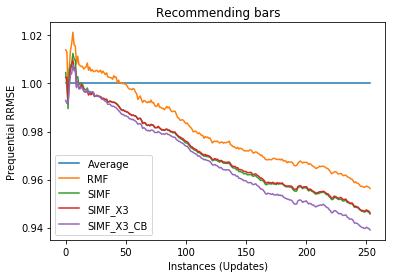

In [15]:
plot_results(results, title='Recommending bars')